## Определение перспективного тарифа для телеком компании


Нашей задачей является анализ тарифных планов компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В проекте будет реализован предварительный анализ тарифов на небольшой выборке клиентов. У нас есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. В данном проекте мы проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

## Описание данных

Таблица `users` (информация о пользователях):

* `user_id` — уникальный идентификатор пользователя
*`first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):

* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):

* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):

* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `ub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

### Обзор данных

In [2]:
# загружаем файлы с данными

try:
    calls = pd.read_csv('calls.csv')
except FileNotFoundError:
    calls = pd.read_csv('/datasets/calls.csv')

try:
    internet = pd.read_csv('internet.csv')
except FileNotFoundError:
    internet = pd.read_csv('/datasets/internet.csv')   
    
try:
    messages = pd.read_csv('messages.csv')
except FileNotFoundError:
    messages = pd.read_csv('/datasets/messages.csv')  
    
try:
    tariffs = pd.read_csv('tariffs.csv')
except FileNotFoundError:
    tariffs = pd.read_csv('/datasets/tariffs.csv')      
    
try:
    users = pd.read_csv('users.csv')
except FileNotFoundError:
    users = pd.read_csv('/datasets/users.csv')      

data_list = [calls, internet, messages, tariffs, users]

**Посмотрим и подготовим таблицу звонков**

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
# приведем дату к datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

In [6]:
# округлим длительность разговора в большую сторону и приведем к целому значению
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [7]:
# приведем id к int
calls['id'] = calls['id'].astype('int')

In [8]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


**Посмотрим и подготовим таблицу интернет-сессий**

In [10]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
# приведем дату к datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')

In [13]:
# округлим трафик в большую сторону и приведем к целому значению
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

In [14]:
# приведем id к int
internet['id'] = internet['id'].astype('int')

In [15]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,10000,113,2018-11-25,1000
1,1,10001,1053,2018-09-07,1000
2,2,10002,1198,2018-06-25,1000
3,3,10003,551,2018-08-22,1000
4,4,10004,303,2018-09-24,1000


In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  int64         
 2   mb_used       149396 non-null  int64         
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 5.7 MB


**Посмотрим и подготовим таблицу сообщений**

In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
# приведем дату к datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

In [20]:
# приведем id к int
messages['id'] = messages['id'].astype('int')

In [21]:
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


**Посмотрим и подготовим таблицу тарифов**

In [23]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [24]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [25]:
# переименуем столбец с тарфом в соответствии с таблицей пользователей
tariffs = tariffs.rename(columns = {'tariff_name': 'tariff'})

**Посмотрим и подготовим таблицу пользователей**

In [26]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [27]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [28]:
# приведем даты к datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

38 человек прекратили пользование тарифом

## Подготовка данных

**Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам**

In [29]:
# добавим колонку месяца в таблицу звонков
calls['month'] = calls['call_date'].dt.month

In [30]:
user_calls = (calls.groupby(['user_id', 'month'])
                  .agg({'id':'count', 'duration':'sum'})
                  .reset_index()
                  .rename(columns={'id':'calls_total_in_month', 'duration':'calls_duration_in_month'})
             )
user_calls.head()

,user_id,month,calls_total_in_month,calls_duration_in_month
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


**Посчитаем количество отправленных сообщений по месяцам**

In [31]:
# добавим колонку месяца в таблицу сообщений
messages['month'] = messages['message_date'].dt.month

In [32]:
user_messages = (messages.groupby(['user_id', 'month'])
                        .agg({'id': 'count'})
                        .reset_index()
                        .rename(columns={'id':'messages_total_in_month'})
                )
user_messages.head()

,user_id,month,messages_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Посчитаем объем израсходованного интернет-трафика по месяцам**

In [33]:
# добавим колонку месяца в таблицу интернет-трафика
internet['month'] = internet['session_date'].dt.month

In [34]:
user_internet = (internet.groupby(['user_id', 'month'])
                         .agg({'mb_used': 'sum'})
                         .reset_index()
                         .rename(columns={'mb_used': 'gb_total_in_month'})
                )
user_internet['gb_total_in_month'] = np.ceil((user_internet['gb_total_in_month']/1024))
user_internet


,user_id,month,gb_total_in_month
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
...,...,...,...
3198,1498,10,21.0
3199,1499,9,2.0
3200,1499,10,18.0
3201,1499,11,18.0


**Посчитаем помесячную выручку с каждого пользователя**

In [35]:
# сформируем  таблицу, где объединим данные о звонках, сообщениях, интернет-траффике по месяцам
user_total = user_calls.merge(user_messages, on = ['user_id', 'month'], how = 'outer')
user_total = user_total.merge(user_internet, on = ['user_id', 'month'], how = 'outer')
user_total

,user_id,month,calls_total_in_month,calls_duration_in_month,messages_total_in_month,gb_total_in_month
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17.0
3210,1489,10,NaN,NaN,21.0,20.0
3211,1489,11,NaN,NaN,20.0,18.0
3212,1489,12,NaN,NaN,35.0,17.0


In [36]:
# добавим столбец с городом и  тарифом, к которому он подключен
user_total = user_total.merge(users[['user_id', 'city', 'tariff']], on = 'user_id', how = 'outer')
user_total                              

,user_id,month,calls_total_in_month,calls_duration_in_month,messages_total_in_month,gb_total_in_month,city,tariff
0,1000,5.0,22.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,60.0,23.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,75.0,14.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,81.0,14.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,57.0,15.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,18.0,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17.0,Санкт-Петербург,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


In [37]:
# избавимся от пропущенных значений
user_total = user_total.fillna(0)

In [38]:
# напишем фунцию для подсчета выручки
def calc_revenue(row):
    
    x = 1 if row['tariff'] == 'ultra' else 0
        
    tariff_msg_limit = tariffs.loc[x, 'messages_included']
    tariff_rub_per_msg = tariffs.loc[x, 'rub_per_message']
        
    tariff_calls_limit = tariffs.loc[x, 'minutes_included']
    tariff_rub_per_min = tariffs.loc[x, 'rub_per_minute']
        
    tariff_gb_limit = tariffs.loc[x, 'mb_per_month_included']/1024
    tariff_rub_per_gb = tariffs.loc[x, 'rub_per_gb']
    
    revenue = tariffs.loc[x, 'rub_monthly_fee']
    
    if row['calls_total_in_month'] > tariff_calls_limit:
        revenue += (row['calls_total_in_month'] - tariff_calls_limit)*tariff_rub_per_min

    if row['messages_total_in_month'] > tariff_msg_limit:
        revenue += (row['messages_total_in_month'] - tariff_msg_limit)*tariff_rub_per_msg
    
    if row['gb_total_in_month'] > tariff_gb_limit:
        revenue += (row['gb_total_in_month'] - tariff_gb_limit)*tariff_rub_per_gb       

    return revenue

In [39]:
# посчитаем выручку для каждого пользователя
user_total['revenue'] = 0
user_total['revenue'] = user_total.apply(lambda x: calc_revenue(x), axis=1)

In [40]:
user_total.head(10)

,user_id,month,calls_total_in_month,calls_duration_in_month,messages_total_in_month,gb_total_in_month,city,tariff,revenue
0,1000,5.0,22.0,159.0,22.0,3.0,Краснодар,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,Краснодар,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,Краснодар,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,Краснодар,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,Краснодар,ultra,1950.0
5,1000,10.0,57.0,350.0,73.0,15.0,Краснодар,ultra,1950.0
6,1000,11.0,43.0,338.0,58.0,15.0,Краснодар,ultra,1950.0
7,1000,12.0,46.0,333.0,70.0,10.0,Краснодар,ultra,1950.0
8,1001,11.0,59.0,430.0,0.0,19.0,Москва,smart,1350.0
9,1001,12.0,63.0,414.0,0.0,14.0,Москва,smart,550.0


## Анализ данных

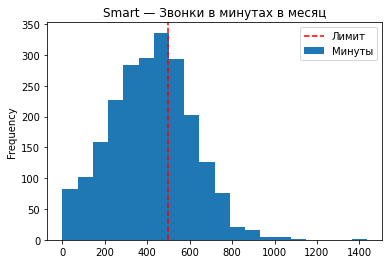

In [41]:
# посмотрим на звонки тарифа "Смарт" 
user_total[user_total['tariff'] == 'smart']['calls_duration_in_month'].plot(kind='hist', bins=20, label = "Минуты")
limit = tariffs.loc[0, 'minutes_included']
plt.title('Smart — Звонки в минутах в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

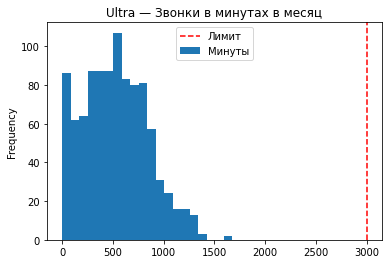

In [42]:
# посмотрим на звонки тарифа "Ультра" 
user_total[user_total['tariff'] == 'ultra']['calls_duration_in_month'].plot(kind='hist', bins=20, label = "Минуты")
limit = tariffs.loc[1, 'minutes_included']
plt.title('Ultra — Звонки в минутах в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

In [43]:
# посмотрим на медиану, среднее, дисперсию и стд отклонение каждого тарифа
user_total.groupby('tariff')\
  .agg({'calls_duration_in_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

На тарифе "Смарт" пользователи в большей степени стараются уложиться в лимит 500 минут. В среднем они разговаривают по 420 минут. Есть правый хвост в распределении,который говорит нам что, есть пользователи которые разговаривают сверх лимита, количество их снижается. Возможно, им выгоднее будет перейти на тариф "Ультра".  
По тарифу "Ультра" в среднем пользователи разговаривают 520 минут, разброс довольно большой, т.к. лимит на звонки довольный высокий. Никто не выходит за пределы лимита.

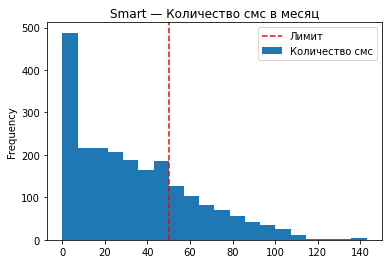

In [44]:
# посмотрим на сообщения тарифа "Смарт" 
user_total[user_total['tariff'] == 'smart']['messages_total_in_month'].plot(kind='hist', bins=20, label = "Количество смс")
limit = tariffs.loc[0, 'messages_included']
plt.title('Smart — Количество смс в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

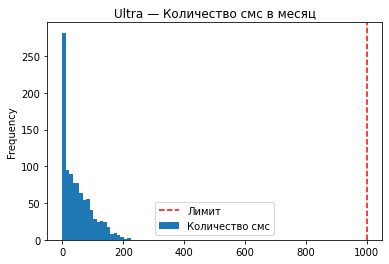

In [45]:
# посмотрим на сообщения тарифа "Ультра" 
user_total[user_total['tariff'] == 'ultra']['messages_total_in_month'].plot(kind='hist', bins=20, label = "Количество смс")
limit = tariffs.loc[1, 'messages_included']
plt.title('Ultra — Количество смс в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

In [46]:
# посмотрим на медиану, среднее, дисперсию и стд отклонение каждого тарифа
user_total.groupby('tariff')\
  .agg({'messages_total_in_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

Видим, что большинство пользователей на обоих тарифах очень мало пользуются SMS-сообщениями - способ общения непопулярный. Оба распределения имеют смещение влево. На тарифе "Смарт" есть пользователи, которые не укладываются в лимит по тарифу, в "Ультре" все в рамках лимита.

In [47]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


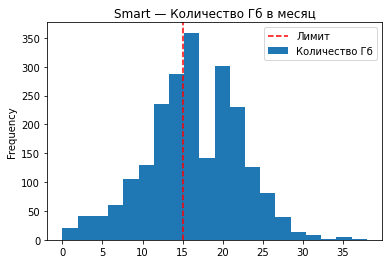

In [48]:
# посмотрим на интернет трафик тарифа "Смарт" 
user_total[user_total['tariff'] == 'smart']['gb_total_in_month'].plot(kind='hist', bins=20, label = "Количество Гб")
limit = tariffs.loc[0, 'mb_per_month_included']/1024
plt.title('Smart — Количество Гб в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

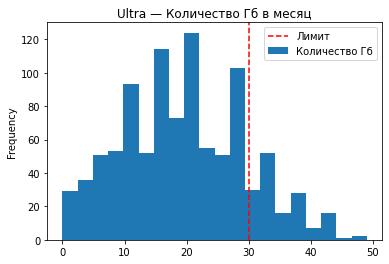

In [49]:
# посмотрим на интернет трафик тарифа "Ультра" 
user_total[user_total['tariff'] == 'ultra']['gb_total_in_month'].plot(kind='hist', bins=20, label = "Количество Гб")
limit = tariffs.loc[1, 'mb_per_month_included']/1024
plt.title('Ultra — Количество Гб в месяц')
plt.axvline(limit, c = 'r', ls = '--', label = 'Лимит')
plt.legend()
plt.show()

In [50]:
# посмотрим на медиану, среднее, дисперсию и стд отклонение каждого тарифа
user_total.groupby('tariff')\
  .agg({'gb_total_in_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

Видим, что медиана и средние у обоих тарифах лежат рядом, но на "Ультра" разброс значений выше. На тарифе "Смарт" большая часть пользователей использует интернет сверх лимита.   
На "Ультре" из-за увеличенного тарифа пользователи в основном укладываются в лимиты по трафику (среднее и медиана ниже лимита в 30 Гб), но есть и те, которые используют интернет свыше лимита.

## Проверка гипотез

*Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.*

### Гипотеза №1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются ###

**Сформулируем гипотезы:**

- H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
- H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

In [51]:
# разобъем пользователей по тарифам 
smart = user_total[user_total['tariff'] == 'smart']['revenue']
ultra = user_total[user_total['tariff'] == 'ultra']['revenue']

In [52]:
print('Средняя выручка тарифа "smart": {:.1f}'.format(smart.mean()))
print('Средняя выручка тарифа "ultra": {:.1f}'.format(ultra.mean()))
print('Полная выручка тарифа "smart": {:.1f}'.format(smart.sum()))
print('Полная выручка тарифа "ultra": {:.1f}'.format(ultra.sum()))
print('Количество пользователей тарифа "smart": {}'.format(smart.count()))
print('Количество пользователей тарифа "ultra": {}'.format(ultra.count()))


Средняя выручка тарифа "smart": 1169.5
Средняя выручка тарифа "ultra": 2070.9
Полная выручка тарифа "smart": 2608084.0
Полная выручка тарифа "ultra": 2041950.0
Количество пользователей тарифа "smart": 2230
Количество пользователей тарифа "ultra": 986


In [53]:
# примем 
alpha = 0.05

In [54]:
results = st.ttest_ind(ultra, smart)

In [55]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.957723028588673e-239
Отвергаем нулевую гипотезу


Выручка пользователей тарифов «Ультра» и «Смарт» различается


### Гипотеза №2: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. ###

**Сформулируем гипотезы:**

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [56]:
# посмотрим города
user_total['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [57]:
# разобъем пользователей на Москву и другие регионы
user_moscow = user_total[user_total['city'] == 'Москва']['revenue']
user_other = user_total[user_total['city'] != 'Москва']['revenue']

In [58]:
# примем 
alpha = 0.05

In [59]:
results = st.ttest_ind(user_moscow, user_other)

In [60]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.2854624966111559
Не получилось отвергнуть нулевую гипотезу


С вероятностью в 28% и выше такой результат может быть получен случайно. Это слишком большая вероятность, чтобы делать выводы о значимом различиии между средней выручкой пользователей из Москвы и пользователей из других регионов.

## Общие выводы

Мы провели сравнительный анализ тарифов "Смарт" и "Ультра". 

Тариф "Смарт" имеет более низкую абонентскую плату и высокие ограничения по тарифу.  
Тариф "Ультра"имеет высокую абонентскую плату и широкий пакет включенных минут, SMS сообщений и интернета.  
Суммарная выручка больше у тарифа "Смарт", т.к. этот тариф имеет больше количество пользователей.  
Средние по звонкам, смс и интернет трафику у тарифов схожи. SMS сообщениями мало кто пользуется.  
В тарифе "Ультра" основная выручка идет из-за абонентской платы, а не превышения тарифных условий как это происходит в тарифе "Смарт".   
Тариф "Ультра" имеет неоправдано большие лимиты по услугам, большинству пользователей столько не нужно.  
Выручка в различных городах и в Москве с вероятностью 24% и выше не различаются.  
Тариф "Смарт" популярнее т.к. имеет относительно низкую абонентскую плату, но он покрывает основные потребности пользователя. Возможно можно создать новый тариф на основе "Смарт", но оптимизированного за счет широкого (с неоправданно большими лимитами) пакета "Ультра" и незначительного повышения абонентской платы. Гибрид рассмотренных тарифов.